<a href="https://colab.research.google.com/github/andysingal/machine-learning/blob/main/dimension_reduction_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
sys.path.insert(0, '..')

**PCA aims to find the directions of maximum variance in high-dimensional data and projects the data onto a new subspace with equal or fewer dimensions than the original one**

**Eigendecomposition, the factorization of a square matrix into so-called eigenvalues and eigenvectors, is at the core of the PCA procedure described in this section.**

In [4]:
%%capture
!pip install wandb

Notebook Color Scheme:


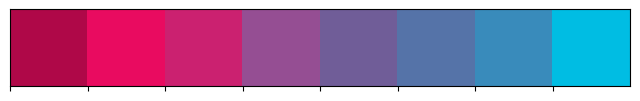

In [20]:
# Libraries
import os
import gc
import wandb
import time
import random
import math
import glob
from scipy import spatial
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
from numpy import dot, sqrt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from IPython.display import display_html
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
plt.rcParams.update({'font.size': 16})

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib.colors import ListedColormap

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'HandM', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[95m'
    E = '\033[0m'
    
my_colors = ["#AF0848", "#E90B60", "#CB2170", "#954E93", "#705D98", "#5573A8", "#398BBB", "#00BDE3"]
print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()



In [23]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

In [8]:


df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

print(clr.S+"WINES DATASET:"+clr.E, df_wine.shape)
display_html(df_wine.head(3))

WINES DATASET: (178, 14)


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


#PREPROCESSING

In [9]:
# 🐝 W&B Experiment
run = wandb.init(project='HandM', name='WINES DATASET', config=CONFIG)

<IPython.core.display.Javascript object>

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


In [10]:
print(clr.S+"There are no missing values in any columns but 'Detail Description':"+clr.E,
      df_wine.isna().sum()[-1], "total missing values")

There are no missing values in any columns but 'Detail Description': 0 total missing values


In [12]:
print(clr.S+"Number of unique article_ids within wine.data:"+clr.E, len(df_wine))

# 🐝 Log Distinct article IDs
wandb.log({"article_ids":len(df_wine)})



Number of unique article_ids within wine.data: 178


In [14]:
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)
    

#Standardizing the data.
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

#Eigendecomposition of the covariance matrix.

In [15]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n', eigen_vals)


Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


Eigendecomposition in NumPy

The numpy.linalg.eig function was designed to operate on both symmetric and non-symmetric square matrices. However, you may find that it returns complex eigenvalues in certain cases.

A related function, numpy.linalg.eigh, has been implemented to decompose Hermetian matrices, which is a numerically more stable approach to working with symmetric matrices such as the covariance matrix; numpy.linalg.eigh always returns real eigenvalues. 

**The eigenvalues define the magnitude of the eigenvectors, so we have to sort the eigenvalues by decreasing magnitude; we are interested in the top k eigenvectors based on the values of their corresponding eigenvalues.**

#Total and explained variance

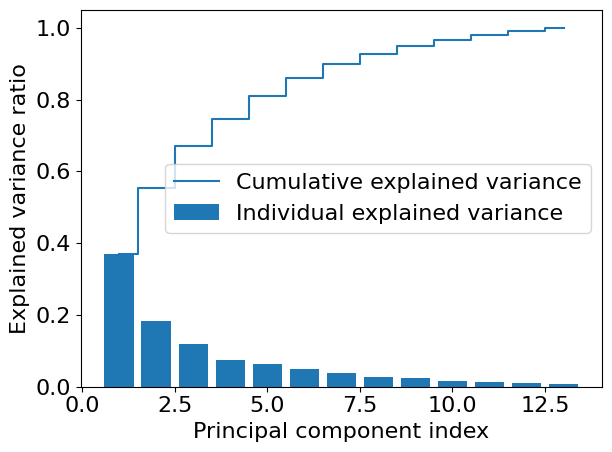

In [16]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, 14), var_exp, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('figures/05_02.png', dpi=300)
plt.show()

#Feature transformation

In [17]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


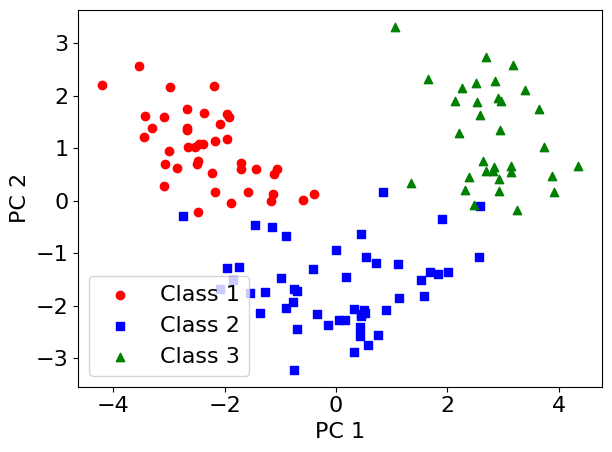

In [18]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_03.png', dpi=300)
plt.show()

#Principal component analysis in scikit-learn

In [22]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

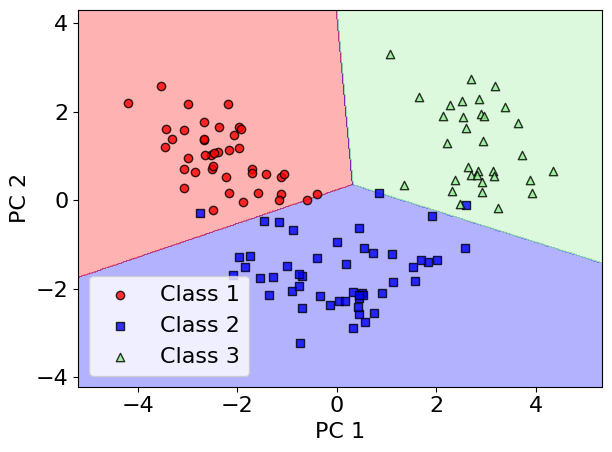

In [24]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_04.png', dpi=300)
plt.show()

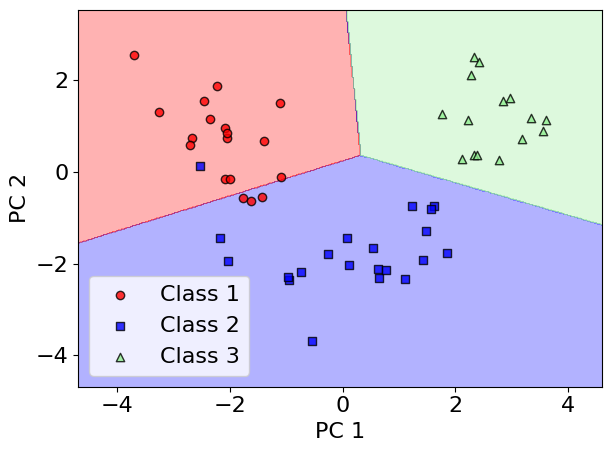

In [25]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_05.png', dpi=300)
plt.show()

#FEATURE IMPORTANCE

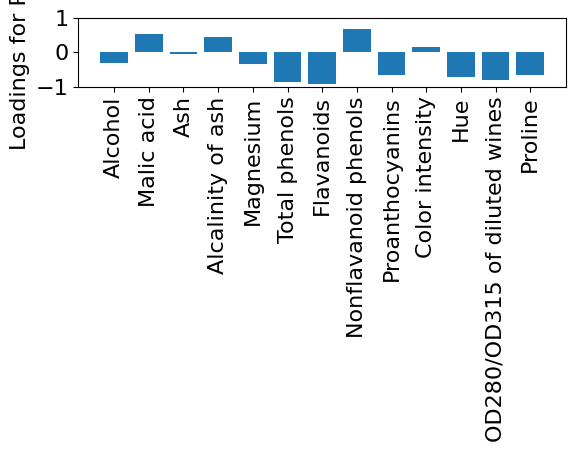

In [27]:
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, ax = plt.subplots()

ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

#Visualizing data via t-distributed stochastic neighbor embedding

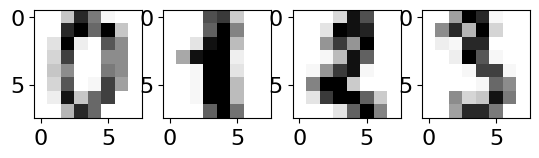

In [29]:
from sklearn.datasets import load_digits

digits = load_digits()

fig, ax = plt.subplots(1, 4)
y_digits = digits.target
X_digits = digits.data

for i in range(4):
    ax[i].imshow(digits.images[i], cmap='Greys')
    
# plt.savefig('figures/05_12.png', dpi=300)
plt.show() 

In [30]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2,
            init='pca',
            random_state=123)
X_digits_tsne = tsne.fit_transform(X_digits)

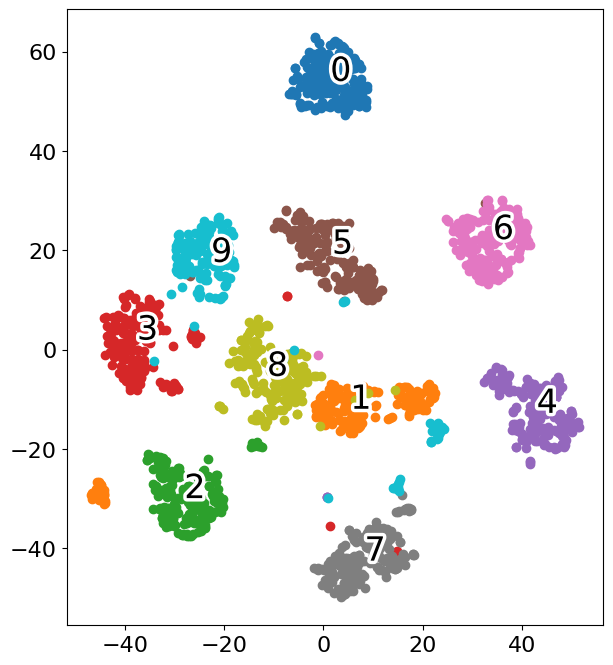

In [31]:
import matplotlib.patheffects as PathEffects


def plot_projection(x, colors):
    
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for i in range(10):
        plt.scatter(x[colors == i, 0],
                    x[colors == i, 1])

    for i in range(10):

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        
plot_projection(X_digits_tsne, y_digits)
# plt.savefig('figures/05_13.png', dpi=300)
plt.show()